In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.optim as optim

import functions as fun

### function to learn:

In [2]:
which = 'p3b'

plot of the function to learn:

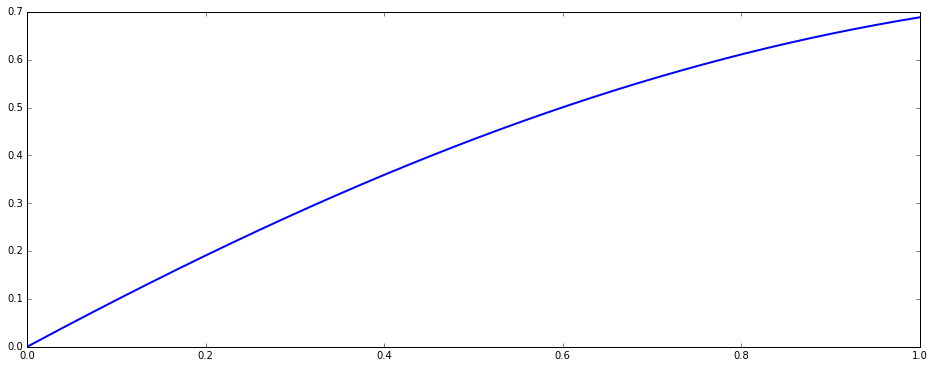

In [3]:
x_min_show, x_max_show = fun.interval[which]
x_show = torch.arange(x_min_show, x_max_show, 0.001)
y_show = fun.function[which](x_show)
plt.figure(figsize=(16, 6))
plt.plot(x_show.numpy(), y_show.numpy(), linewidth=2)
plt.show()

model parameters:
* D_in: dimension of the input
* H: dimension of the hidden layer
* D_out: dimension of the output

In [4]:
D_in, H, D_out = 1, 10, 1

#### training set:

In [5]:
x_min, x_max = fun.interval[which]
n_train = 10 #number of points in the training set
step = (x_max-x_min)/n_train
x_train = torch.arange(x_min, x_max, step).view(-1, 1)
#xtrain = torch.cat((xtrain, torch.Tensor([2]).view(-1, 1)))
y_train = fun.function[which](x_train) 

x = Variable(x_train)
y = Variable(y_train, requires_grad=False)

### Neural net:

In [6]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

#loss_fn = torch.nn.MSELoss(size_average=False)
criterion = torch.nn.L1Loss(size_average=False)
#optimizer = optim.SGD(seq.parameters(), lr = 5e-6, momentum=0.9)
optimizer = optim.Adam(seq.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

#### Learning:

In [7]:
n_epoch = 80000
Loss = []
for t in tqdm(range(n_epoch)):    
    y_pred = fun.trial[which](seq, x)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    Loss.append(loss.data.numpy()[0])

100%|██████████| 80000/80000 [00:31<00:00, 2571.49it/s]


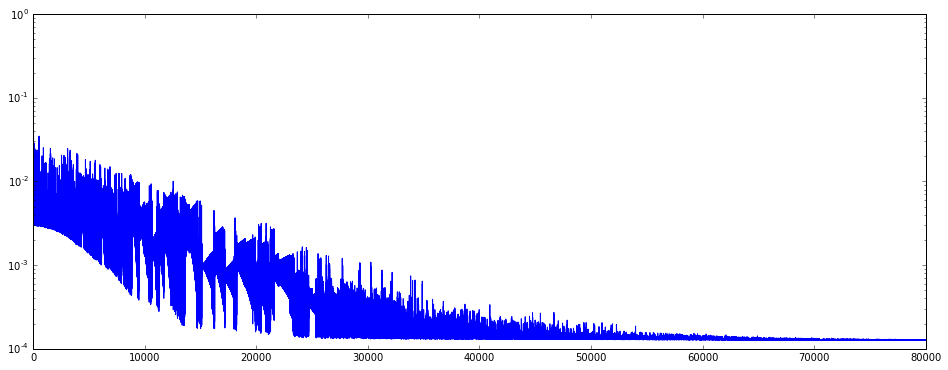

In [8]:
plt.figure(figsize=(16, 6))
plt.semilogy(Loss) 
plt.show()

### Testing:

In [9]:
n_test = 1000
x_min_test, x_max_test = fun.interval[which]
step_test = (x_max_test-x_min_test)/n_test
x_test = Variable(torch.arange(x_min_test, x_max_test, step_test).view(-1, 1))
y_test = fun.function[which](x_test)

##### Trial solution:

In [10]:
y_pred = fun.trial[which](seq, x_test)
print(criterion(y_pred[:int(len(y_pred)/2)], y_test[:int(len(y_pred)/2)]))

Variable containing:
1.00000e-03 *
  7.7176
[torch.FloatTensor of size 1]



#### Plot of results:

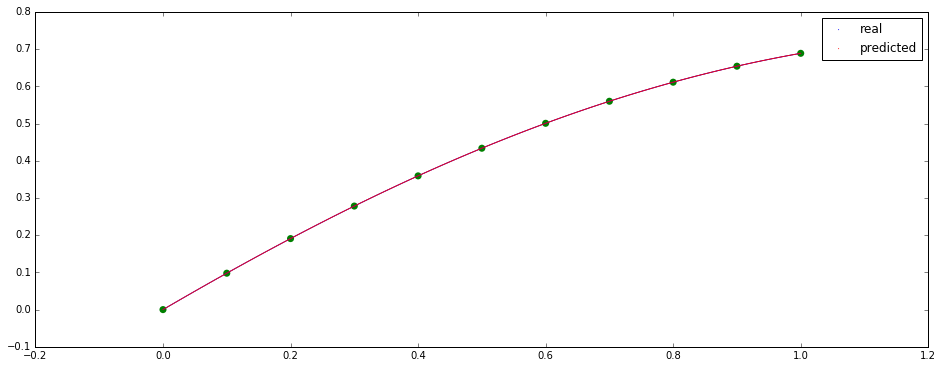

In [11]:
plt.figure(figsize=(16, 6))
plt.scatter(x.data.numpy(), y.data.numpy(), c='g', s=50, edgecolors='none') #training set
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='b', s=1, edgecolors='none', label='real') # test real
plt.scatter(x_test.data.numpy(), y_pred.data.numpy(), c='r', s=1, edgecolors='none', label='predicted') # test predicted
plt.legend(scatterpoints=1)
plt.show()

### Error:

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


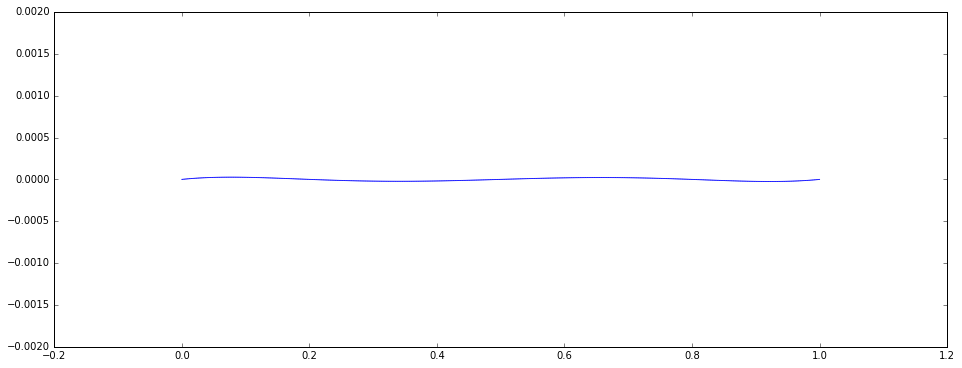

In [12]:
plt.figure(figsize=(16, 6))
plt.scatter(x_test.data.numpy(), (y_test-y_pred).data.numpy(), s=1, edgecolors='none')
plt.legend(scatterpoints=1)
plt.show()

### Naive solution (linear interpolation):

In [13]:
def naive(xtrain, ytrain, xtest):
    ytest = []
    x_max_train = xtrain.numpy()[-1]
    for x in xtest:
        if x.data.numpy()[0] >= x_max_train:
            ytest.append(0)
            continue
        for i, xt in enumerate(xtrain):
            #print(x.data.numpy())#, xt.numpy()[0])
            if x.data.numpy()[0] < xt.numpy()[0]:
                ytest.append(float((ytrain[i-1] + (ytrain[i]-ytrain[i-1])*(x.data.numpy()[0]-xtrain[i-1])/(xtrain[i]-xtrain[i-1])).numpy()[0]))
                break
    return ytest

In [14]:
y_naive = naive(x_train, y_train, x_test)

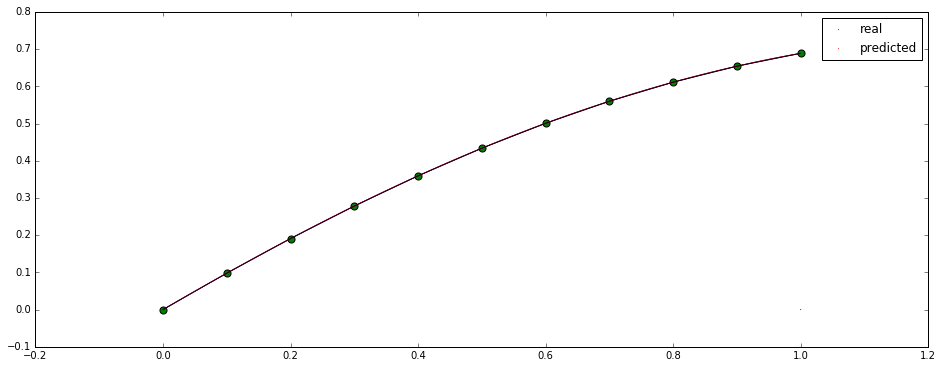

In [15]:
plt.figure(figsize=(16, 6))
plt.scatter(x.data.numpy(), y.data.numpy(), c='g', s=50) #training set
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='b', s=1, edgecolors='none', label='real') # test real
plt.scatter(x_test.data.numpy(), y_pred.data.numpy(), c='r', s=1, edgecolors='none', label='predicted') # test predicted
plt.scatter(x_test.data.numpy(), y_naive, c='k', s=1, edgecolors='none')
plt.legend(scatterpoints=1)
plt.show()

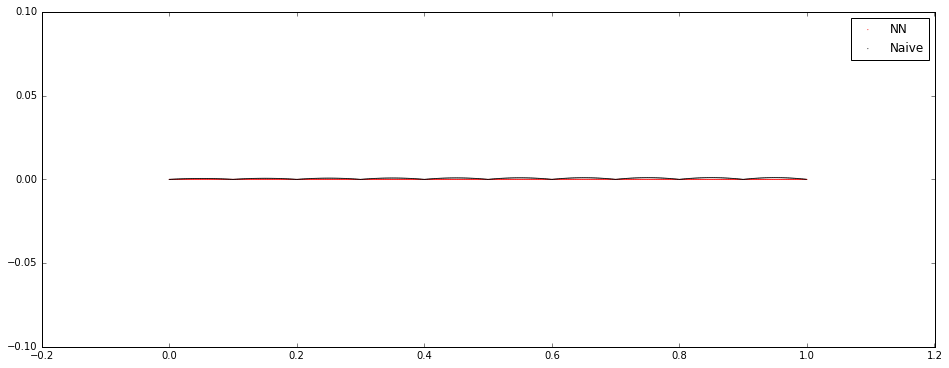

In [16]:
plt.figure(figsize=(16, 6))
plt.scatter(x_test.data.numpy(), (y_test-y_pred).data.numpy(), s=1, c='r', edgecolors='none', label='NN')
plt.scatter(x_test.data.numpy(), y_test.view(1, -1).data.numpy()-y_naive, s=1, c='k', edgecolors='none', label='Naive')
plt.legend(scatterpoints=1)
plt.ylim(-0.1, 0.1)
plt.show()

In [17]:
print('predicted:', criterion(y_pred[:int(len(y_pred)/2)], y_test[:int(len(y_pred)/2)]))
print('naive:', criterion(Variable(torch.Tensor(y_naive[:int(len(y_pred)/2)])), y_test[:int(len(y_pred)/2)]))

predicted: Variable containing:
1.00000e-03 *
  7.7176
[torch.FloatTensor of size 1]

naive: Variable containing:
 0.2439
[torch.FloatTensor of size 1]

